# 01 - Data Overview
Quick look at processed tables and basic distributions.

In [1]:
import os
import sys
from pathlib import Path
ROOT = Path(os.getcwd()).resolve()
if (ROOT / 'src').exists():
    sys.path.append(str(ROOT))
elif (ROOT.parent / 'src').exists():
    sys.path.append(str(ROOT.parent))
else:
    sys.path.append(str(ROOT))

raw_candidates = [
    ROOT / 'data/raw/data.json',
    ROOT.parent / 'data/raw/data.json',
]
raw_path = next((p for p in raw_candidates if p.exists()), None)
if raw_path is None:
    raise FileNotFoundError(f'data/raw/data.json introuvable. Cherché: {raw_candidates}')

processed_dir = ROOT / 'data/processed'
processed_dir.mkdir(parents=True, exist_ok=True)

import polars as pl
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from src.dota_data import read_processed_tables, match_header, kill_participation, write_parquet_tables

sns.set_theme(style='whitegrid')

if not (processed_dir / 'matches.parquet').exists():
    write_parquet_tables(raw_path, processed_dir)

tables = read_processed_tables(processed_dir)
matches = match_header(tables['matches'])
players = tables['players']
objectives = tables['objectives']
teamfights = tables['teamfights']

(matches.shape, players.shape, objectives.shape, teamfights.shape)


((50, 11), (500, 149), (1485, 11), (2020, 19))

In [2]:
# Winrate global et par patch
winrate = matches.select(pl.col("radiant_win").mean().alias("radiant_winrate"))
winrate_patch = matches.group_by("patch").agg(pl.col("radiant_win").mean().alias("radiant_winrate"))
display(winrate)
display(winrate_patch.sort("patch"))

radiant_winrate
f64
0.48


patch,radiant_winrate
i64,f64
58,0.48


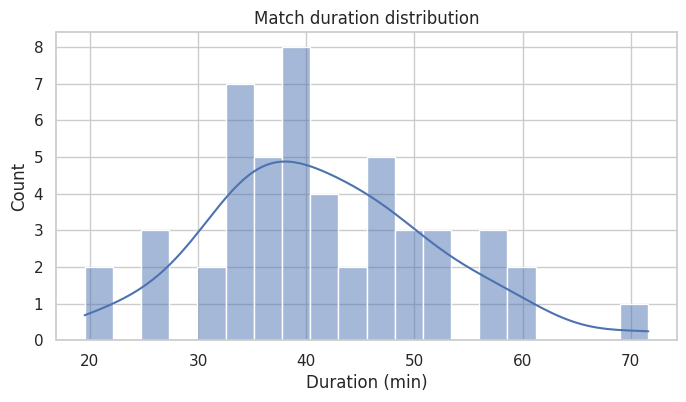

In [ ]:
# Distribution des durees (minutes)
df_matches = matches.to_pandas()
df_matches["duration_min"] = df_matches["duration"] / 60
plt.figure(figsize=(8,4))
sns.histplot(df_matches["duration_min"], bins=20, kde=True)
plt.xlabel("Duration (min)")
plt.title("Match duration distribution")
plt.show()

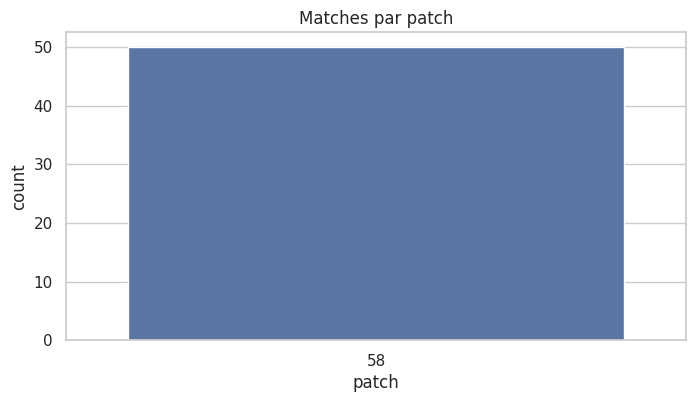

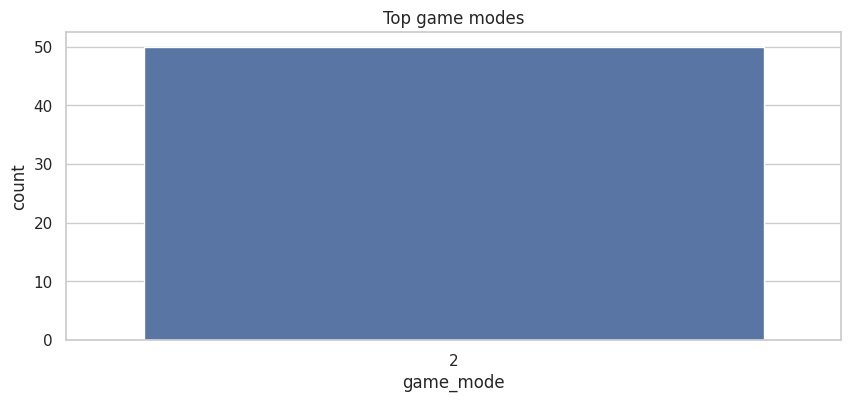

In [4]:
# Patch et modes les plus frequents
plt.figure(figsize=(8,4))
sns.countplot(data=df_matches, x="patch")
plt.title("Matches par patch")
plt.show()

plt.figure(figsize=(10,4))
top_modes = df_matches["game_mode"].value_counts().head(10)
sns.barplot(x=top_modes.index, y=top_modes.values)
plt.title("Top game modes")
plt.xlabel("game_mode")
plt.ylabel("count")
plt.show()

In [5]:
# Valeurs manquantes (top 10)
nulls = (matches.null_count() / len(matches)).to_pandas().T
nulls = nulls.melt(var_name="column", value_name="null_ratio")
nulls = nulls.sort_values("null_ratio", ascending=False)
display(nulls.head(10))

,column,null_ratio
0,0,0.0
1,0,0.0
2,0,0.0
3,0,0.0
4,0,0.0
5,0,0.0
6,0,0.0
7,0,0.0
8,0,0.0
9,0,0.0


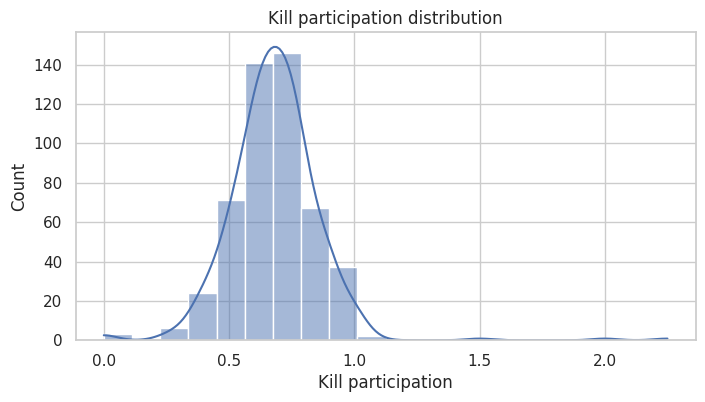

,match_id,player_slot,hero_id,kills,assists,team_kills,kill_participation
count,5.000000e+02,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,8.546756e+09,66.000000,75.104000,4.452000,10.644000,22.260000,0.681857
std,2.248672e+07,64.079735,37.602621,3.725514,6.109986,10.339546,0.183600
min,8.514308e+09,0.000000,2.000000,0.000000,0.000000,1.000000,0.000000
25%,8.528068e+09,2.000000,49.000000,1.000000,6.000000,13.000000,0.590241
50%,8.539896e+09,66.000000,70.000000,4.000000,10.000000,21.500000,0.684211
75%,8.576076e+09,130.000000,102.000000,7.000000,15.000000,30.000000,0.769231
max,8.592273e+09,132.000000,145.000000,23.000000,36.000000,45.000000,2.250000


In [6]:
# Kill participation distribution
kp = kill_participation(players).to_pandas()
plt.figure(figsize=(8,4))
sns.histplot(kp["kill_participation"].dropna(), bins=20, kde=True)
plt.xlabel("Kill participation")
plt.title("Kill participation distribution")
plt.show()
kp.describe()